In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

In [2]:
df = pd.read_csv("wine-reviews.csv", usecols=['country','description','points','price','variety','winery'])

In [3]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [4]:
df=df.dropna(subset=["description","points"])

(array([  397.,   692.,  1836.,  3025.,  6480.,  9530., 12600., 16933.,
        17207., 12226., 15410., 11359.,  9613.,  6489.,  3758.,  1535.,
          523.,   229.,    77.,    52.]),
 array([ 80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,
         91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99., 100.]),
 <BarContainer object of 20 artists>)

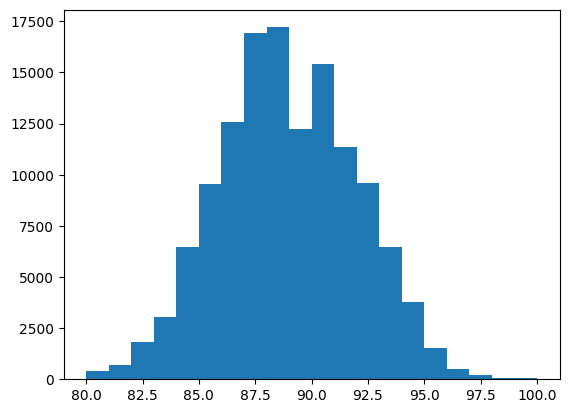

In [5]:
plt.hist(df.points,bins=20)

In [6]:
df["label"]=(df.points>=90).astype(int)
df=df[["description","points","label"]]


In [7]:
train, val, test=np.split(df.sample(frac=1),[int(0.8*len(df)),int(0.9*len(df))])

In [8]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df=dataframe.copy()
  labels=df.pop('label')
  df=df["description"]
  ds=tf.data.Dataset.from_tensor_slices((df,labels))
  if shuffle:
    ds=ds.shuffle(buffer_size=len(dataframe))
  ds=ds.batch(batch_size)
  ds=ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [9]:
train_data=df_to_dataset(train)
valid_data=df_to_dataset(val)
test_data=df_to_dataset(test)

In [10]:
list(train_data)[0]

(<tf.Tensor: shape=(1024,), dtype=string, numpy=
 array([b'Lifted aloe vera notes and ripe Conference pears harmonize on the nose. The palate is sleek and sculptured by buffered acidity and a deeply satisfying core of rich, phenolic fruitiness. This convinces with absolute authenticity and an intriguing, almost primal edge of floral aromatics.',
        b'A floral nose greets you at first sniff, followed by hints of light citrus. A mix of grapefruit, melon and apple flavors are light and enticing, keeping the wine delicate and balanced. The finish leaves an impression of lemon tea.',
        b'Floral and fruit fragrances suggest lemon blossom, stone fruit and citrus. The fresh palate offers juicy peach, creamy apple and lemon zest accompanied by firm acidity. It closes fresh and clean.',
        ...,
        b"A fruity wine, just touched by some wood aging with attractive strawberry fruit flavors and acidity. It's not a wine for aging, its light minerality enhancing the fruitiness.",
 

In [11]:
embedding="http://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer=hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [12]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.46342593, -0.1004212 , -0.02387425, ..., -0.1164172 ,
        -0.32903674, -0.01762227],
       [ 0.35356292, -0.34262398, -0.11490314, ..., -0.04627256,
         0.06598519,  0.2274603 ],
       [ 0.30685326, -0.25113037, -0.22628437, ..., -0.07611345,
        -0.15225352,  0.09404918],
       ...,
       [ 0.39158022,  0.07167447,  0.04837951, ..., -0.16851519,
        -0.08207139,  0.19698033],
       [ 0.45943972, -0.2311225 , -0.18519926, ...,  0.20292291,
        -0.21022958, -0.02005472],
       [ 0.57506996, -0.15921952,  0.14956006, ..., -0.03484086,
        -0.33231527,  0.05010141]], dtype=float32)>

In [13]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16,activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))   #done to reduce overfitting
model.add(tf.keras.layers.Dense(16,activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))    #done to reduce overfitting
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [15]:
model.evaluate(train_data)

102/102 [==============================] - 2s 11ms/step - loss: 0.6782 - accuracy: 0.6210


[0.6782130002975464, 0.6209894418716431]

In [16]:
model.evaluate(valid_data)

13/13 [==============================] - 0s 11ms/step - loss: 0.6785 - accuracy: 0.6220


[0.6785488724708557, 0.6219896674156189]

In [17]:
history=model.fit(train_data, epochs=10,validation_data=valid_data)

Epoch 1/10
102/102 [==============================] - 132s 1s/step - loss: 0.6251 - accuracy: 0.6358 - val_loss: 0.4892 - val_accuracy: 0.7824
Epoch 2/10
102/102 [==============================] - 131s 1s/step - loss: 0.4654 - accuracy: 0.7843 - val_loss: 0.3909 - val_accuracy: 0.8236
Epoch 3/10
102/102 [==============================] - 140s 1s/step - loss: 0.3954 - accuracy: 0.8280 - val_loss: 0.3716 - val_accuracy: 0.8283
Epoch 4/10
102/102 [==============================] - 133s 1s/step - loss: 0.3605 - accuracy: 0.8468 - val_loss: 0.3665 - val_accuracy: 0.8333
Epoch 5/10
102/102 [==============================] - 132s 1s/step - loss: 0.3356 - accuracy: 0.8587 - val_loss: 0.3698 - val_accuracy: 0.8342
Epoch 6/10
102/102 [==============================] - 133s 1s/step - loss: 0.3155 - accuracy: 0.8675 - val_loss: 0.3709 - val_accuracy: 0.8369
Epoch 7/10
102/102 [==============================] - 132s 1s/step - loss: 0.2970 - accuracy: 0.8759 - val_loss: 0.3817 - val_accuracy: 0.8361

In [18]:
model.evaluate(test_data)

13/13 [==============================] - 5s 398ms/step - loss: 0.4329 - accuracy: 0.8320


[0.4328573942184448, 0.8319741487503052]

<h1>LSTM</h1>

In [19]:
encoder=tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label:text))

In [20]:
vocab=np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [22]:
model1=tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(16,activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

In [23]:
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [25]:
model1.evaluate(train_data)
model1.evaluate(valid_data)

13/13 [==============================] - 2s 148ms/step - loss: 0.6939 - accuracy: 0.4220


[0.6938866376876831, 0.42202046513557434]

In [28]:
history1=model1.fit(train_data, epochs=5,validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 51s 450ms/step - loss: 0.5607 - accuracy: 0.7072 - val_loss: 0.3773 - val_accuracy: 0.8350
Epoch 2/5
102/102 [==============================] - 44s 429ms/step - loss: 0.3845 - accuracy: 0.8336 - val_loss: 0.3477 - val_accuracy: 0.8453
Epoch 3/5
102/102 [==============================] - 45s 440ms/step - loss: 0.3654 - accuracy: 0.8422 - val_loss: 0.3443 - val_accuracy: 0.8453
Epoch 4/5
102/102 [==============================] - 47s 459ms/step - loss: 0.3561 - accuracy: 0.8466 - val_loss: 0.3410 - val_accuracy: 0.8458
Epoch 5/5
102/102 [==============================] - 44s 434ms/step - loss: 0.3486 - accuracy: 0.8499 - val_loss: 0.3402 - val_accuracy: 0.8455


In [29]:
model1.evaluate(test_data)

13/13 [==============================] - 2s 159ms/step - loss: 0.3479 - accuracy: 0.8367


[0.3479355573654175, 0.8367441296577454]